# Mount

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/My\ Drive/TESIS/autism-master/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/TESIS/autism-master


Plan: reveer el preprocesamiento y de la serie temporal a los diagramas en un pipeline claro, focalizándonos en que el código funcione y poder tener control de lo que está pasando. 

Idealmente también, tener toda la secuencia de códigos desde el comienzo del dato crudo hasta el output de los modelos.

La idea es usar este pipeline completo para hacer benchmarking con otros datasets de homología persistente y probar la clasificación.

# Librerías

In [ ]:
import os
import pandas as pd 
import numpy as np
from scipy import sparse
!pip install pingouin
import pingouin as pg
!pip install git+https://github.com/paris-saclay-cds/ramp-workflow
from problem import get_train_data
from download_data import fetch_fmri_time_series
!pip install ripser
from ripser import ripser
from persim import plot_diagrams
!pip install tensorflow_addons  
!pip install gudhi
import pickle as pkl
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit
from tensorflow import random_uniform_initializer as rui
import gudhi.representations as tda
import tensorflow as tf
import os.path
import itertools
import h5py
import tensorflow_addons  as tfa
import gudhi              as gd
from scipy.sparse           import csgraph
from scipy.io               import loadmat
from scipy.linalg           import eigh
from sklearn.preprocessing  import LabelEncoder, OneHotEncoder
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
# Reduccion dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
!pip install git+https://github.com/MathieuCarriere/perslay
!pip install git+https://github.com/MathieuCarriere/sklearn-tda
from perslay import PerslayModel
from scipy.stats import beta
!pip install nilearn
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
import generate_sequences

# Código

Este es el código del preprocesamiento

In [ ]:
#fetch_fmri_time_series(atlas='basc_197')

data_train, labels_train = get_train_data()
data_train_functional = data_train[[col for col in data_train.columns if col.startswith('fmri')]]
data_train_functional['tmp'] = data_train_functional.index

In [ ]:
def get_all_patients(ids_list, parcelation):
  pacientes = []
  for ID in ids_list:
    path = data_train_functional.loc[data_train_functional['tmp'] == ID, parcelation].item()
    paciente=pd.read_csv(path)
    paciente = np.asarray(paciente)
    pacientes.append(paciente)
  return pacientes


def gen_matrices(lista_pacientes, tipo_matriz, as_distance, keep_pvalue = 1):
  """ lista_pacientes debe ser una lista de arrays de numpy de (n_obs,n_features) cada una
  Y tipo_matriz puede ser cualquiera de 'correlation', 'partial correlation', 'tangent', y 'precision'
  El parámetro as_distance controla si se transforma la matriz a distancia coseno ('cosine'), distancia dinámica ('dynamic'), o ninguna (False)
  Si as_distance no es Falso y la matriz es tangente, entonces usa el argumento máximo para MinMaxScale
  El parámetro keep_pvalue descarta (solo para la matriz de correlación) aquellas correlaciones con significatividad menor a keep_pvalue
  (ej, keep_pvalue = 0.1 deja solamente las correlaciones con p-valor menor o igual a 0.1)
  """
  connect = ConnectivityMeasure(kind = tipo_matriz)
  matrices = connect.fit_transform(lista_pacientes)

  if (keep_pvalue < 1) and (tipo_matriz == 'correlation'):
    for i in range(matrices.shape[0]):
      matrix = non_trivial_correlation(lista_pacientes[i], matrices[i], threshold = keep_pvalue)
      matrices[i] = matrix
  if (as_distance == 'cosine') and (tipo_matriz != 'tangent'):
    for i in range(matrices.shape[0]):
      matrices[i] = np.sqrt(2*(1-matrices[i]))
  if (as_distance == 'dynamic') and (tipo_matriz != 'tangent'):
    for i in range(matrices.shape[0]):
      matrices[i] = 1-np.abs(matrices[i])

  if (as_distance == 'cosine') and (tipo_matriz == 'tangent'):
    max_value = np.amax(np.abs(matrices)) + 0.1
    for i in range(matrices.shape[0]):
      matrices[i] = np.sqrt(2*(1-matrices[i]/max_value))
  if (as_distance == 'dynamic') and (tipo_matriz == 'tangent'):
    max_value = np.amax(np.abs(matrices)) + 0.1
    for i in range(matrices.shape[0]):
      matrices[i] = 1-np.abs(matrices[i]/max_value)

  return matrices

def non_trivial_correlation(X, corrmat, threshold=0.1): # Ver https://stackoverflow.com/questions/59416390/how-can-i-compute-the-pearson-correlation-matrix-and-retain-only-significant-val
    n = X.shape[0] # Es para hacer el threshold del p-valor
    p = 2 * beta(n/2 - 1, n/2 - 1, loc=-1, scale=2).cdf(-abs(corrmat))
    corrmat[p > threshold] = 0
    return corrmat

def triag_array(array):
    return(array[np.triu_indices_from(array)])

def ripser_diagram(paciente, hom_over_p=2, hom_dimension = 1, distm = True):
    diag = ripser(paciente, distance_matrix=distm, coeff = hom_over_p, maxdim=hom_dimension)['dgms']
    return(diag)


In [ ]:
with open('train/data_paciente.pkl', 'rb') as handle:
    data_paciente = pkl.load(handle)

data_train_functional = data_train_functional.merge(data_paciente[['id','label']], right_on='id', left_on='tmp')

In [ ]:
with open('train/train_ids.pkl', 'rb') as handle:
    train_ids = pkl.load(handle)

In [ ]:
train_ids = list(train_ids)

In [ ]:
pacientes = get_all_patients(train_ids, 'fmri_basc197')

In [ ]:
tipo_mat = 'partial correlation'
tipo_dist = 'dynamic'
parc_id = 'fmri_basc197'

t1 = time()

paciente_mat = gen_matrices(pacientes, tipo_matriz = tipo_mat, as_distance = tipo_dist, keep_pvalue = 0.05)

t2 = time()
print(t2-t1)

path = 'train/prueba_semana26/train_matrix_' + tipo_mat + '_' + tipo_dist +'_' + parc_id + '.pkl'
with open(path, 'wb') as handle:
  pkl.dump(paciente_mat, handle, protocol=pkl.HIGHEST_PROTOCOL)

t1 = time()
dgms = []
Len = len(paciente_mat)
for i in range(Len):
  dgm = ripser_diagram(paciente_mat[i])
  dgms.append(dgm)

t2 = time()
print(t2-t1)

path = 'train/prueba_semana26/train_dgms_' + tipo_mat + '_' + tipo_dist +'_' + parc_id + '.pkl'
with open(path, 'wb') as handle:
  pkl.dump(dgms, handle, protocol=pkl.HIGHEST_PROTOCOL)

7.768146753311157
185.69669604301453


In [ ]:
#16:40  tangent, cosine. 120.69609308242798 segundos en hacer los diagramas!!!!!
# 17:13 tangent, dynamic.
# 17:22 correlation, cosine
# 17: 25 correlation, dynamic
# 17:28 partial, cosine
# 17:33 partial, dynamic

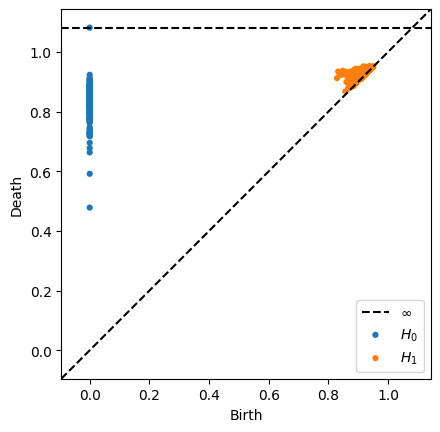

In [ ]:
plot_diagrams(dgms[700])

# Sigue

Una vez preprocesado se pueden abrir los archivos y trabajar directamente hasta el modelo

In [ ]:
#with open('autism-master/train/train_dgms_fmri_basc197.pkl', 'rb') as handle:
#    train_dgms = pkl.load(handle)

#Ahora el objeto se llama dgms

Len = len(dgms)
diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}

for i in range(Len):
  diags_dict['Rips_dim_0'].append(dgms[i][0])
  diags_dict['Rips_dim_1'].append(dgms[i][1])


F = np.array([[]]*Len)


In [ ]:
def diag_prepro(diags_dict, use_selector = True, use_prominent = True, thresh = 500, use_scaler = True, use_padding = True):
  
  # https://gudhi.inria.fr/python/3.1.0.rc1/representations.html
  # Whole pipeline
  tmp = Pipeline([
          ("Selector",      tda.DiagramSelector(use=True, point_type="finite")),
          ("ProminentPts",  tda.ProminentPoints(use=True, num_pts=thresh)),
          ("Scaler",        tda.DiagramScaler(use=True, scalers=[([0,1], MinMaxScaler())])),
          ("Padding",       tda.Padding(use=True)),
                  ])

  prm = {filt: {"ProminentPts__num_pts": min(thresh, max([len(dgm) for dgm in diags_dict[filt]]))} 
        for filt in diags_dict.keys() if max([len(dgm) for dgm in diags_dict[filt]]) > 0}

  # Apply the previous pipeline on the different filtrations.
  diags = []
  for dt in prm.keys():
      param = prm[dt]
      tmp.set_params(**param)
      diags.append(tmp.fit_transform(diags_dict[dt]))

  # For each filtration, concatenate all diagrams in a single array.
  D, npts = [], len(diags[0])
  for dt in range(len(prm.keys())):
      D.append(np.array(np.concatenate([diags[dt][i][np.newaxis,:] for i in range(npts)],axis=0),dtype=np.float32))
  
  return D

def load_architecture_params(weight, len_d, layer = "Image", perm_op = "mean"):
  perslay_parameters = []
  perslay_channel = {}

  perslay_channel["pweight_train"] = True
  perslay_channel["layer_train"]   = True
  perslay_channel["final_model"]   = tf.keras.Sequential([tf.keras.layers.Flatten()])

  if layer == "Landscape":
    perslay_channel["layer"]           = "Landscape"
    perslay_channel["lsample_num"]     = 100
    perslay_channel["lsample_init"]    = rui(0.0, 1.0)

  if layer == "Image":
    perslay_channel["layer"]           = "Image"
    perslay_channel["image_size"]      = (20, 20)
    perslay_channel["image_bnds"]      = ((-.001, 2.001), (-.001, 2.001))
    perslay_channel["lvariance_init"]  = 3.


  if weight == "gmix":
    perslay_channel["pweight"]       = "gmix"
    perslay_channel["pweight_num"]   = 3
    perslay_channel["pweight_init"]  = np.array(np.vstack([np.random.uniform(0.,1.,[2,3]),
                                                           5.*np.ones([2,3])]), dtype=np.float32)
  if weight == "power":
    perslay_channel["pweight"]       = "power"
    perslay_channel["pweight_init"]  = 1.
    perslay_channel["pweight_power"] = 1

  if weight == "grid":
    perslay_channel["pweight"]       = "grid"
    perslay_channel["pweight_size"]  = [20,20]
    perslay_channel["pweight_bnds"]  = ((-.001, 1.001), (-.001, 1.001))
    perslay_channel["pweight_init"]  = rui(1.0, 1.0)
  
  if weight == "None":
    perslay_channel["pweight"]       = None

  perslay_channel["perm_op"] = perm_op
  # mean, max, sum, topk

  if perm_op == "topk":
    perslay_channel["keep"]  = 10

  perslay_parameters = [perslay_channel for _ in range(len_d)]

  return perslay_parameters

def vector_representations(D, perslay_parameters):
  mirrored_strategy = tf.distribute.MirroredStrategy()
  with mirrored_strategy.scope():
      
      # Final rho network is a simple dense layer to the number of labels 
      rho = tf.keras.Sequential([tf.keras.layers.Dense(L.shape[1], activation="sigmoid", input_shape=(800,))])
      model = PerslayModel(name="PersLay", diagdim=2, perslay_parameters=perslay_parameters, rho=rho)

      # Optimizer is Adam with exponential decay of learning rate and moving average of variables
      lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.01, decay_steps=20, decay_rate=0.5)
      optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-4)
      optimizer = tfa.optimizers.MovingAverage(optimizer, average_decay=0.9) 

      # Loss is cross-entropy
      loss = tf.keras.losses.CategoricalCrossentropy()

      # Metric is accuracy
      metrics = [tf.keras.metrics.CategoricalAccuracy()]

  vectors = model.compute_representations(D).numpy()
  return vectors

random_seed=1003
def reduceDim(df, target, method_class = PCA, df_name='Dataset',  **method_params):
    plt.figure(figsize=(10,10))
    plt.title('Reducción de dimensionalidad con {0} para dataset {1}'.format(method_class.__name__, df_name))
    
    target_df=pd.DataFrame({'ind': target.index, 'className': target.values})
    
    method_instance = method_class(n_components=2, random_state = random_seed)
    method_instance.set_params(**method_params)
    principalComponents = method_instance.fit_transform(df)
    
    if method_class == PCA:
        print('Varianza explicada',method_instance.explained_variance_ratio_)
        print('Varianza explicada total',method_instance.explained_variance_ratio_.sum())
    if method_class == TSNE:
        print(' .. cantidad de iteraciones: ', method_instance.n_iter_)
        
    principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    principalDf_comp = pd.concat([principalDf.reset_index(drop=True),target_df['className'].reset_index(drop=True)], axis=1)
    sns.scatterplot(data=principalDf_comp, x='PC1', y='PC2',
                    palette=sns.color_palette("hls", 2),
                    hue= "className",
                    s=80)
    plt.show()

In [ ]:
with open('train/train_ids.pkl', 'rb') as handle:
    train_ids = pkl.load(handle)

train_ids = pd.DataFrame(train_ids)
train_ids_labs = train_ids.merge(data_train_functional[['id','label']], on='id')

In [ ]:
path = 'train/prueba_semana26/train_ids_labs.pkl'
with open(path, 'wb') as handle:
  pkl.dump(train_ids_labs, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [ ]:
labs_df = train_ids_labs[['label']]
L = pd.Series(labs_df['label'].values)
L = np.asarray(pd.get_dummies(L))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.7083771  0.19444059]
Varianza explicada total 0.9028177


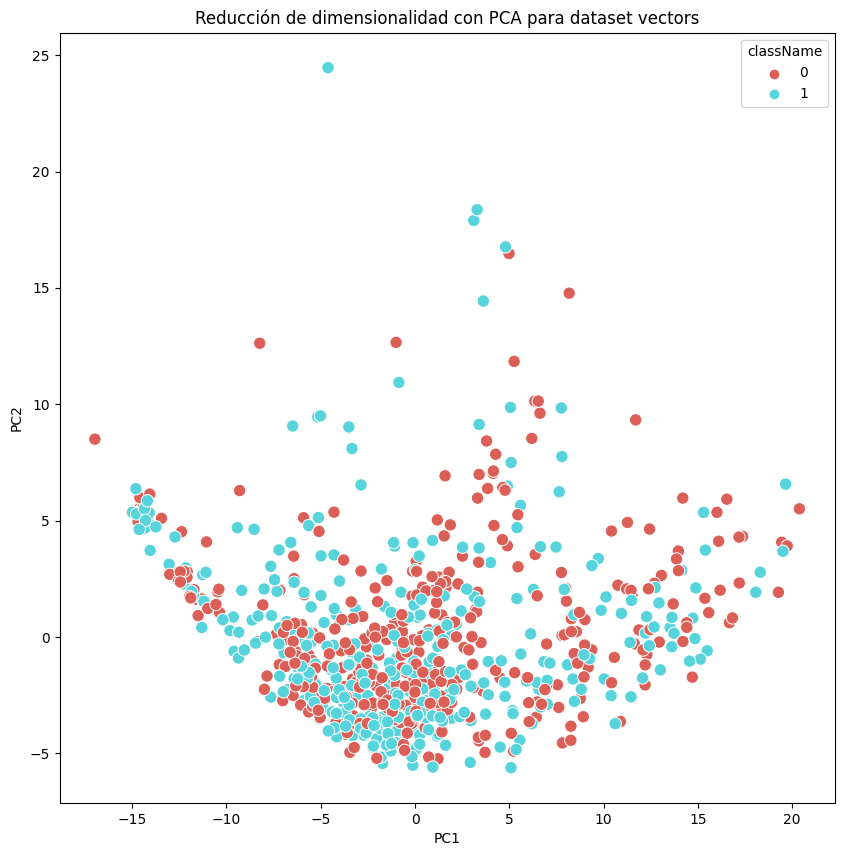

In [ ]:
D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)

lend = len(D)
perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Landscape", perm_op = "sum")
vectors = vector_representations(D, perslay_parameters)

vec_df = pd.DataFrame(vectors)

reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name='vectors')

In [ ]:
import sklearn_tda

In [ ]:
diags_reshape_train = []
for i in range(len(D[0])):
  diags_reshape_train.append(D[1][i].reshape(-1,3)[:,0:2])

num_pts = len(diags_reshape_train)

test_size = .3
random_perm = np.random.permutation(num_pts)
train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

diags_train = []
diags_test = []
for i in train:
  diags_train.append(diags_reshape_train[i])
for i in test:
  diags_test.append(diags_reshape_train[i])

L_arg = np.argmax(L, axis=1)

# SlicedWassersteinKernel
svm = SVC(kernel= 'precomputed')
ker = sklearn_tda.SlicedWassersteinKernel()
ker_fit = ker.fit_transform(diags_train)
svm.fit(ker_fit,L_arg[train])
ker_test = ker.transform(diags_test)
svm.score(ker_test, L_arg[test])

0.5021097046413502

# Benchmarking en secuencias generadas

In [ ]:
!pip install neurodsp
from neurodsp import sim
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum_welch
from neurodsp.plts import plot_time_series, plot_power_spectra

In [ ]:
# Set random seed, for consistency generating simulated data
sim.set_random_seed(21)

def gen_series_tipo1(channels = 100, length = 30):
  # Simulation Settings
  n_seconds = 1
  s_rate = length

  # Compute an array of time values, for plotting, and check length of data
  times = create_times(n_seconds, s_rate)
  n_points = len(times)
  indices = list(range(channels))
  np.random.shuffle(indices)
  freq = np.random.choice([7,10,15])
  expp = np.random.choice([-0.1,-0.5,-1,-1.5])
  components = {
      'sim_oscillation' : {'freq' : freq},
      'sim_powerlaw' : {'exponent' : expp}
  }
  expon = np.random.choice([0.5,1,2,3,4,5])
  SIM = [np.nan]*channels
  for i in range(channels):
    if i < channels//2:
      series = sim.sim_combined(n_seconds, s_rate, components)*i
      series += np.random.normal(0,expon,size = n_seconds*s_rate)
      SIM[indices[i]] = series.tolist()
    else:
      series = np.random.normal(0,1, size = (1,length))
      SIM[indices[i]] = series[0].tolist()
  return np.asarray(SIM)

def gen_series_tipo2(channels = 100, length = 30):
  # Simulation Settings
  n_seconds = 1
  s_rate = length

  # Compute an array of time values, for plotting, and check length of data
  times = create_times(n_seconds, s_rate)
  n_points = len(times)
  indices = list(range(channels))
  np.random.shuffle(indices)
  power = np.random.choice([-1,-2,-3,-4])
  expon = np.random.choice([0.5,1,2,3,4,5])
  SIM = [np.nan]*channels
  for i in range(channels):
    if i < channels//2:
      series = sim.sim_powerlaw(n_seconds, s_rate, exponent=power)*i
      series += np.random.normal(0,expon,size = n_seconds*s_rate)
      SIM[indices[i]] = series.tolist()
    else:
      expon2 = np.random.choice([0.5,1,2,3])
      series = np.random.normal(0,expon2, size = (1,length))
      SIM[indices[i]] = series[0].tolist()
  return np.asarray(SIM)

In [ ]:
labels_bench = []
pacientes_bench = []
samples = 500
for i in range(samples):
  if i < samples//2:
    ser = gen_series_tipo1()
    pacientes_bench.append(ser)
    labels_bench.append(1)
  if i >= samples//2:
    ser = gen_series_tipo2()
    pacientes_bench.append(ser)
    labels_bench.append(0)

In [ ]:
from time import time

In [ ]:
tipo_mat = 'correlation'
tipo_dist = 'dynamic'
parc_id = 'fmri_basc197'

t1 = time()

paciente_mat = gen_matrices(pacientes_bench, tipo_matriz = tipo_mat, as_distance = tipo_dist, keep_pvalue = 0.05)

t2 = time()
print(t2-t1)


t1 = time()
dgms = []
Len = len(paciente_mat)
for i in range(Len):
  dgm = ripser_diagram(paciente_mat[i])
  dgms.append(dgm)



1.2182600498199463


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.8879771  0.10182673]
Varianza explicada total 0.98980385


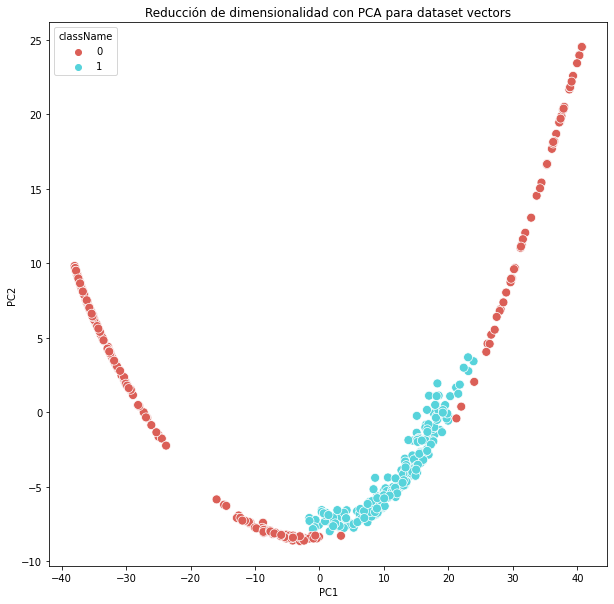

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.7442653  0.22121674]
Varianza explicada total 0.96548206


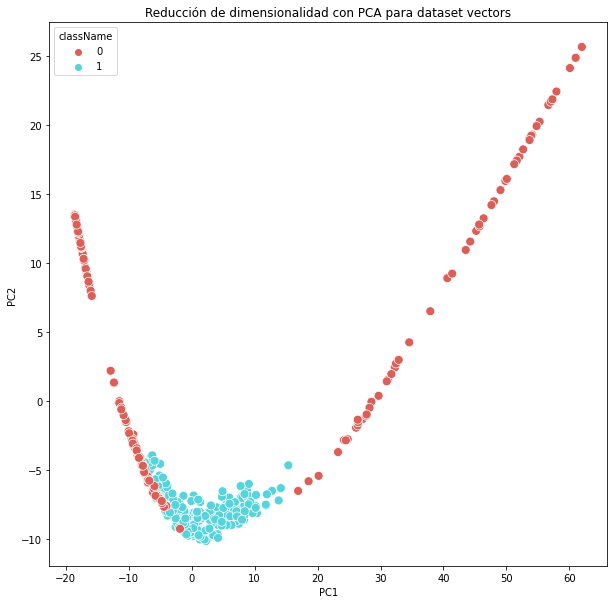

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.6567717  0.30017132]
Varianza explicada total 0.95694304


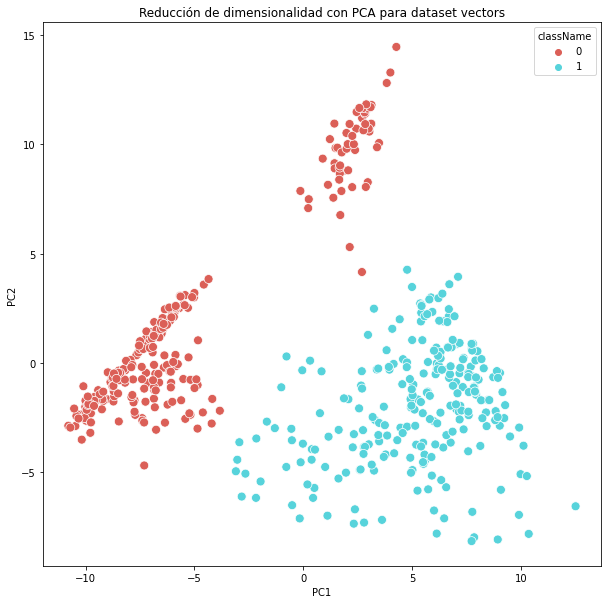

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.7004394  0.21186464]
Varianza explicada total 0.91230404


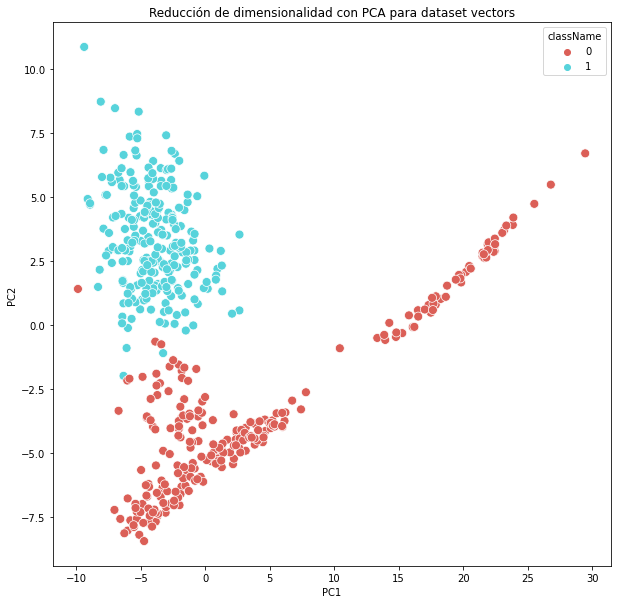

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.8849004  0.07311517]
Varianza explicada total 0.95801556


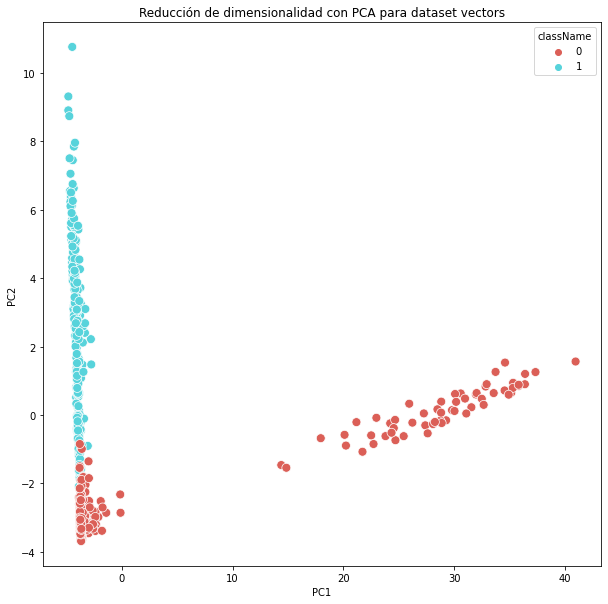

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.84446365 0.07031151]
Varianza explicada total 0.91477513


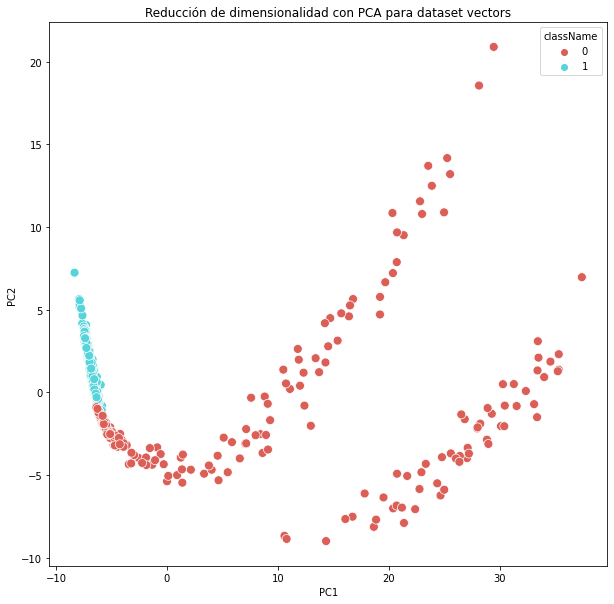

In [ ]:
matrixes = ['correlation', 'partial correlation', 'tangent']
distances = ['cosine', 'dynamic']
parc_id = 'fmri_basc197'

for tipo_mat in matrixes:
  for tipo_dist in distances:
    paciente_mat = gen_matrices(pacientes_bench, tipo_matriz = tipo_mat, as_distance = tipo_dist, keep_pvalue = 0.05)

    dgms = []
    Len = len(paciente_mat)
    for i in range(Len):
      dgm = ripser_diagram(paciente_mat[i])
      dgms.append(dgm)


    diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}
    Len = len(dgms)
    F = np.array([[]]*Len)
    for i in range(Len):
      diags_dict['Rips_dim_0'].append(dgms[i][0])
      diags_dict['Rips_dim_1'].append(dgms[i][1])

    D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)

    labs_df = pd.DataFrame(labels_bench, columns=['label'])
    L = pd.Series(labs_df['label'].values)
    L = np.asarray(pd.get_dummies(L))

    lend = len(D)
    perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Landscape", perm_op = "sum")
    vectors = vector_representations(D, perslay_parameters)

    vec_df = pd.DataFrame(vectors)

    reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name='vectors')

# Scatter de diagramas 

## Diagramas originales

In [ ]:
train_ids = pd.DataFrame(train_ids)
train_ids_labs = train_ids.merge(data_train_functional[['id','label']], on='id')
labs_df = train_ids_labs[['label']]
L = pd.Series(labs_df['label'].values)
L = np.asarray(pd.get_dummies(L))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.9089797 0.044526 ]
Varianza explicada total 0.9535057


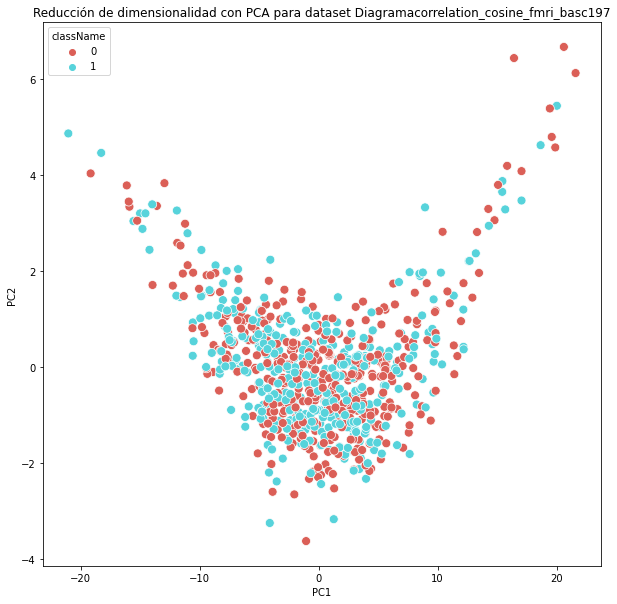

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.8958446  0.05037116]
Varianza explicada total 0.94621575


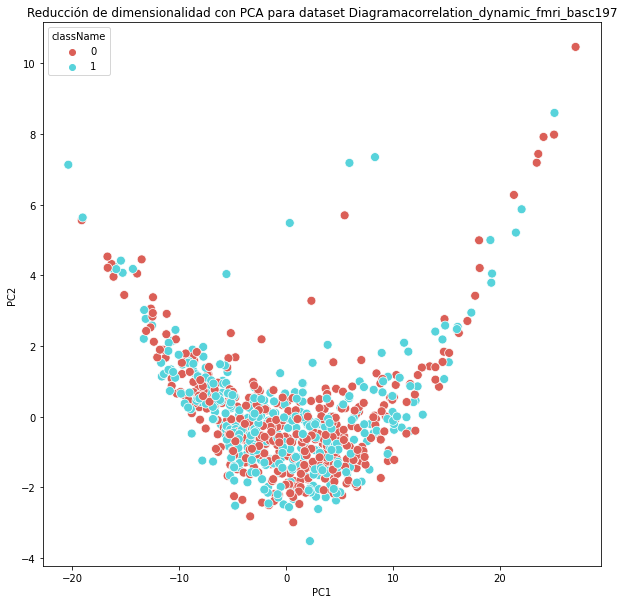

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.7708903  0.13264237]
Varianza explicada total 0.9035327


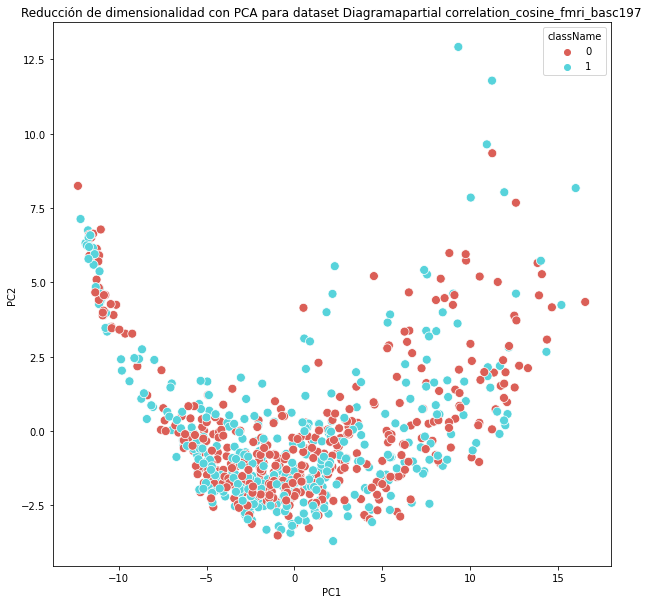

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.6830819 0.1907631]
Varianza explicada total 0.87384504


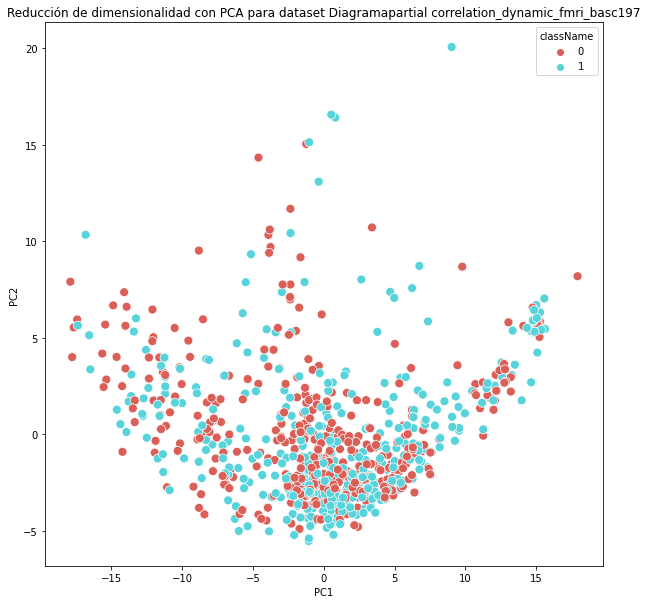

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.40750775 0.28578398]
Varianza explicada total 0.6932917


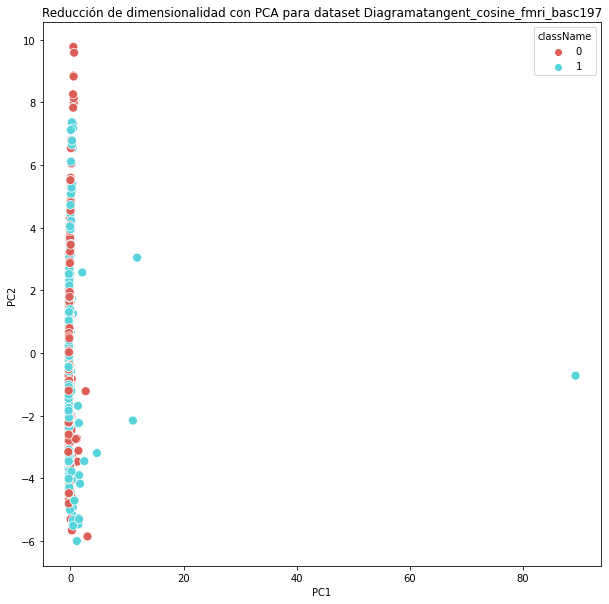

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Varianza explicada [0.450978  0.2183162]
Varianza explicada total 0.66929424


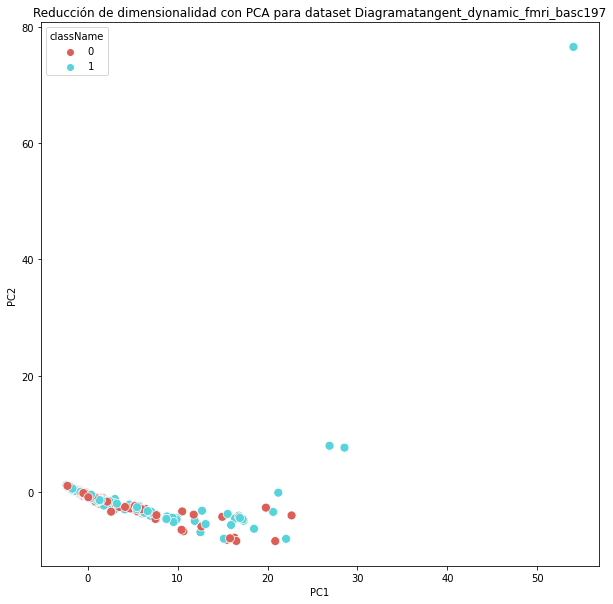

In [ ]:
matrixes = ['correlation', 'partial correlation', 'tangent']
distances = ['cosine', 'dynamic']
parc_id = 'fmri_basc197'

for tipo_mat in matrixes:
  for tipo_dist in distances:
    path = 'train/prueba_semana26/train_dgms_' + tipo_mat + '_' + tipo_dist +'_' + parc_id + '.pkl'
    with open(path, 'rb') as handle:
        dgms = pkl.load(handle)

    Len = len(dgms)
    diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}

    for i in range(Len):
      diags_dict['Rips_dim_0'].append(dgms[i][0])
      diags_dict['Rips_dim_1'].append(dgms[i][1])

    F = np.array([[]]*Len)
    D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)
    lend = len(D)
    perslay_parameters = load_architecture_params(weight="None", len_d = lend, layer= "Landscape", perm_op = "sum")
    vectors = vector_representations(D, perslay_parameters)
    vec_df = pd.DataFrame(vectors)
    name = 'Diagrama' + tipo_mat + '_' + tipo_dist + '_' + parc_id
    reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name= name)


## Matrices vectorizadas

Varianza explicada [0.05629012 0.02834085]
Varianza explicada total 0.0846309746423359


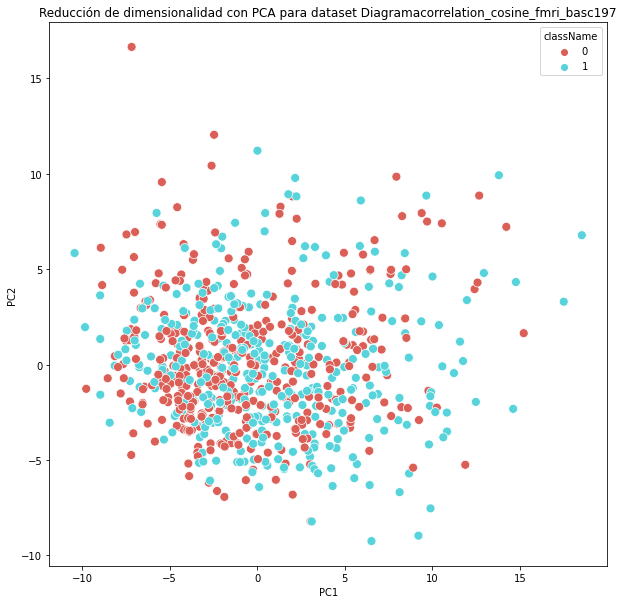

Varianza explicada [0.04129777 0.02698723]
Varianza explicada total 0.06828500000890668


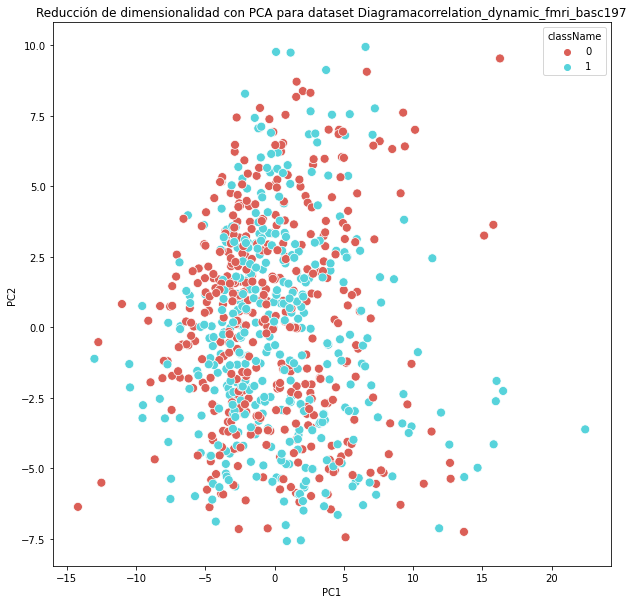

Varianza explicada [0.01258189 0.00765878]
Varianza explicada total 0.02024067101683656


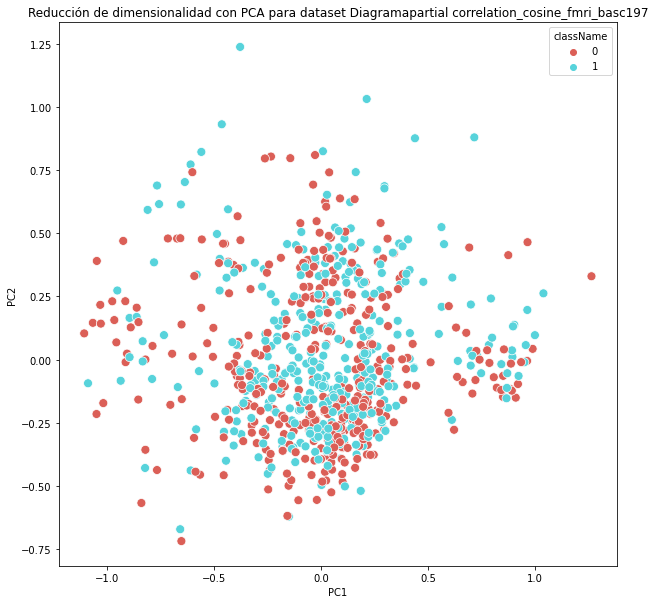

Varianza explicada [0.03871028 0.01507909]
Varianza explicada total 0.05378937382398388


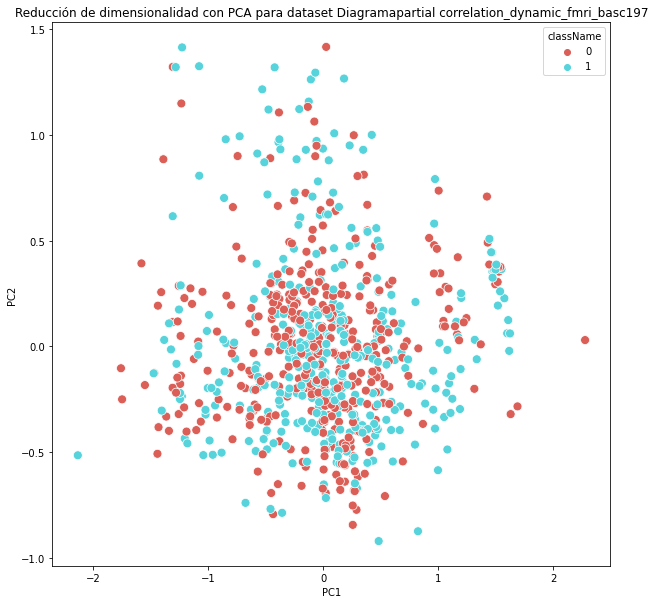

Varianza explicada [0.47758225 0.01224252]
Varianza explicada total 0.4898247669197195


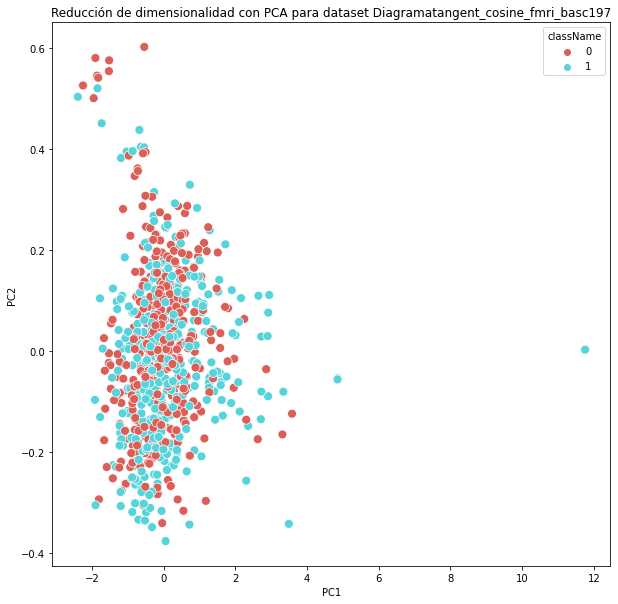

Varianza explicada [0.44673731 0.01364944]
Varianza explicada total 0.4603867499546284


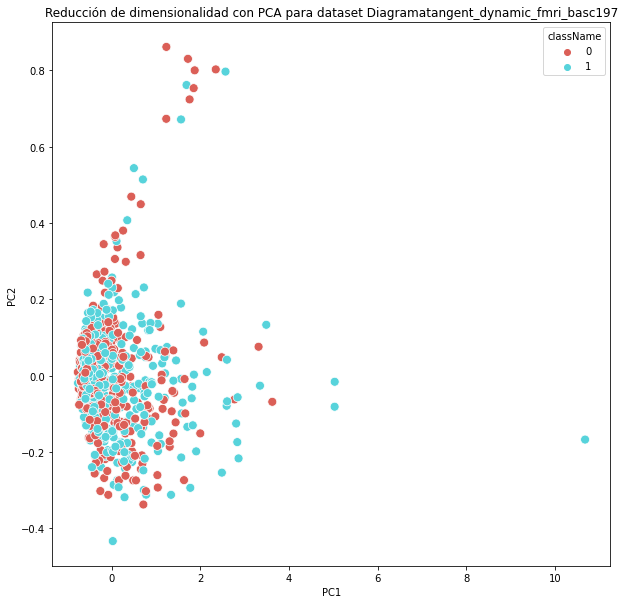

In [ ]:
matrixes = ['correlation', 'partial correlation', 'tangent']
distances = ['cosine', 'dynamic']
parc_id = 'fmri_basc197'

for tipo_mat in matrixes:
  for tipo_dist in distances:
    path = 'train/prueba_semana26/train_matrix_' + tipo_mat + '_' + tipo_dist +'_' + parc_id + '.pkl'
    with open(path, 'rb') as handle:
        mats = pkl.load(handle)
    Len = len(mats)
    F = np.array([[]]*Len)
    mats_triag = []
    for i in range(Len):
      mats_triag.append(triag_array(mats[i]))
    
    vec_df = pd.DataFrame(mats_triag)
    name = 'Diagrama' + tipo_mat + '_' + tipo_dist + '_' + parc_id
    reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name= name)


In [ ]:
data_paciente.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,anatomy_lh_inferiortemporal_area,anatomy_lh_isthmuscingulate_area,anatomy_lh_lateraloccipital_area,anatomy_lh_lateralorbitofrontal_area,anatomy_lh_lingual_area,anatomy_lh_medialorbitofrontal_area,anatomy_lh_middletemporal_area,anatomy_lh_parahippocampal_area,anatomy_lh_paracentral_area,anatomy_lh_parsopercularis_area,anatomy_lh_parsorbitalis_area,anatomy_lh_parstriangularis_area,anatomy_lh_pericalcarine_area,anatomy_lh_postcentral_area,anatomy_lh_posteriorcingulate_area,anatomy_lh_precentral_area,anatomy_lh_precuneus_area,anatomy_lh_rostralanteriorcingulate_area,anatomy_lh_rostralmiddlefrontal_area,anatomy_lh_superiorfrontal_area,anatomy_lh_superiorparietal_area,anatomy_lh_superiortemporal_area,anatomy_lh_supramarginal_area,anatomy_lh_frontalpole_area,anatomy_lh_temporalpole_area,anatomy_lh_transversetemporal_area,anatomy_lh_insula_area,anatomy_lh_WhiteSurfArea_area,anatomy_rh_bankssts_area,anatomy_rh_caudalanteriorcingulate_area,...,anatomy_Right-choroid-plexus,anatomy_5th-Ventricle,anatomy_WM-hypointensities,anatomy_Left-WM-hypointensities,anatomy_Right-WM-hypointensities,anatomy_non-WM-hypointensities,anatomy_Left-non-WM-hypointensities,anatomy_Right-non-WM-hypointensities,anatomy_Optic-Chiasm,anatomy_CC_Posterior,anatomy_CC_Mid_Posterior,anatomy_CC_Central,anatomy_CC_Mid_Anterior,anatomy_CC_Anterior,anatomy_BrainSegVol,anatomy_BrainSegVolNotVentSurf,anatomy_lhCortexVol,anatomy_rhCortexVol,anatomy_CortexVol,anatomy_lhCerebralWhiteMatterVol,anatomy_rhCerebralWhiteMatterVol,anatomy_CerebralWhiteMatterVol,anatomy_SubCortGrayVol,anatomy_TotalGrayVol,anatomy_SupraTentorialVol,anatomy_SupraTentorialVolNotVent,anatomy_SupraTentorialVolNotVentVox,anatomy_MaskVol,anatomy_BrainSegVol-to-eTIV,anatomy_MaskVol-to-eTIV,anatomy_lhSurfaceHoles,anatomy_rhSurfaceHoles,anatomy_SurfaceHoles,anatomy_EstimatedTotalIntraCranialVol,anatomy_eTIV,anatomy_BrainSegVolNotVent,anatomy_select,repetition_time,id,label
subject_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6362958275326218968,22,1,16.00,1049.0,735.0,3157.0,1633.0,409.0,3894.0,5458.0,4634.0,1431.0,6113.0,2872.0,3154.0,2202.0,4265.0,877.0,1560.0,2142.0,848.0,1819.0,1449.0,5238.0,1824.0,5475.0,4533.0,1049.0,8287.0,8122.0,5783.0,4771.0,4589.0,344.0,486.0,447.0,3301.0,103856.0,1106.0,1016.0,...,800.0,0.0,1043.0,0.0,0.0,0.0,0.0,0.0,76.8,1425.9,628.5,745.7,884.7,1248.0,1490487.0,1.452865e+06,329957.014708,325937.569371,655894.584079,282501.533759,279432.730141,561934.263900,73624.0,856918.584079,1.328929e+06,1.296439e+06,1291525.0,1958823.0,0.808868,1.063028,53.0,60.0,113.0,1.842682e+06,1.842682e+06,1452955.0,1,1.5,6362958275326218968,0
7111506141037153650,28,1,12.66,1150.0,752.0,2628.0,1760.0,611.0,3424.0,4090.0,3604.0,1203.0,5569.0,2934.0,3123.0,1642.0,3322.0,684.0,1542.0,1853.0,814.0,1729.0,1492.0,4740.0,1705.0,5531.0,4265.0,951.0,6673.0,8203.0,6216.0,4772.0,5586.0,318.0,488.0,557.0,3001.0,96918.8,945.0,737.0,...,331.0,0.0,903.9,0.0,0.0,0.0,0.0,0.0,103.5,891.5,476.6,1010.1,939.0,885.1,1327255.0,1.316019e+06,296208.260557,296156.677480,592364.938036,247669.727580,244695.595368,492365.322948,68735.0,792125.938036,1.162800e+06,1.155780e+06,1153525.0,1804951.0,0.777365,1.057148,43.0,25.0,68.0,1.707377e+06,1.707377e+06,1316133.0,1,1.0,7111506141037153650,0
15632143337475166470,16,1,11.37,1043.0,603.0,2931.0,1413.0,360.0,3200.0,4511.0,3775.0,1135.0,5996.0,3486.0,3371.0,2077.0,3577.0,657.0,1656.0,1773.0,850.0,1595.0,1067.0,4325.0,1146.0,5351.0,4219.0,814.0,6308.0,8240.0,4977.0,4619.0,4456.0,299.0,501.0,450.0,2880.0,93631.2,1143.0,645.0,...,426.8,0.0,713.8,0.0,0.0,0.0,0.0,0.0,157.7,749.0,521.7,450.9,426.4,876.4,1251012.0,1.236439e+06,314384.748489,310731.083325,625115.831814,204962.880559,204171.778270,40913

In [ ]:
modif = [1 if i == "M" else 0 for i in data_paciente['participants_sex']]

In [ ]:
data_paciente['participants_sex'] = modif

In [ ]:
paciente_dat = data_paciente[data_paciente.columns[~data_paciente.columns.isin(['participants_site','anatomy_select','id','label' ])]]

Varianza explicada [0.73022318 0.16945729]
Varianza explicada total 0.8996804776883933


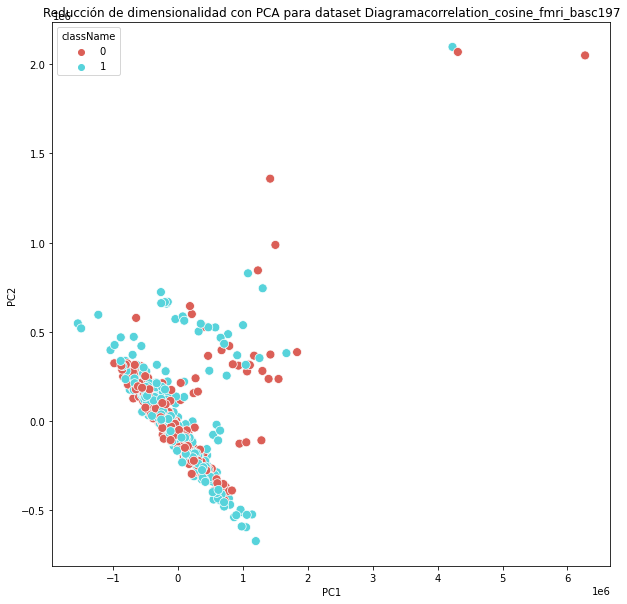

In [ ]:
reduceDim(df=paciente_dat,target=data_paciente['label'], method_class=PCA, df_name= name)

## Modelos rápidos con la vectorización y los diagramas

In [ ]:
matrixes = ['correlation', 'partial correlation', 'tangent']
distances = ['cosine', 'dynamic']
parc_id = 'fmri_basc197'

for tipo_mat in matrixes:
  for tipo_dist in distances:
    path = 'train/prueba_semana26/train_dgms_' + tipo_mat + '_' + tipo_dist +'_' + parc_id + '.pkl'
    with open(path, 'rb') as handle:
        dgms = pkl.load(handle)

    Len = len(dgms)
    diags_dict = {'Rips_dim_0': [],'Rips_dim_1': []}

    for i in range(Len):
      diags_dict['Rips_dim_0'].append(dgms[i][0])
      diags_dict['Rips_dim_1'].append(dgms[i][1])

    F = np.array([[]]*Len)
    D = diag_prepro(diags_dict, use_selector = True, use_prominent = False, thresh = 40, use_scaler = True, use_padding = True)
    lend = len(D)
    diags_reshape_train = []
    for i in range(len(D[0])):
      diags_reshape_train.append(D[1][i].reshape(-1,3)[:,0:2])

    num_pts = len(diags_reshape_train)

    test_size = .3
    random_perm = np.random.permutation(num_pts)
    train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

    diags_train = []
    diags_test = []
    for i in train:
      diags_train.append(diags_reshape_train[i])
    for i in test:
      diags_test.append(diags_reshape_train[i])

    L_arg = np.argmax(L, axis=1)

    # SlicedWassersteinKernel
    svm = SVC(kernel= 'precomputed')
    ker = sklearn_tda.SlicedWassersteinKernel()
    ker_fit = ker.fit_transform(diags_train)
    svm.fit(ker_fit,L_arg[train])
    ker_test = ker.transform(diags_test)

    name = 'Diagrama_SVM_'+ tipo_mat + '_' + tipo_dist + '_' + parc_id
    print(name)
    print(svm.score(ker_test, L_arg[test]))


Diagrama_SVM_correlation_cosine_fmri_basc197
0.48523206751054854
Diagrama_SVM_correlation_dynamic_fmri_basc197
0.5021097046413502
Diagrama_SVM_partial correlation_cosine_fmri_basc197
0.5147679324894515
Diagrama_SVM_partial correlation_dynamic_fmri_basc197
0.510548523206751
Diagrama_SVM_tangent_cosine_fmri_basc197
0.5485232067510548
Diagrama_SVM_tangent_dynamic_fmri_basc197
0.5189873417721519


Con matrices diagonalizadas

In [ ]:
matrixes = ['correlation', 'partial correlation', 'tangent']

for tipo_mat in matrixes:
  mats = gen_matrices(pacientes, tipo_matriz = tipo_mat, as_distance = False, keep_pvalue = 1)
      
  Len = len(mats)
  F = np.array([[]]*Len)
  num_pts = Len

  test_size = .3
  random_perm = np.random.permutation(num_pts)
  train, test = random_perm[:int((1-test_size)*num_pts)], random_perm[int((1-test_size)*num_pts):]

  triang_train = []
  triang_test = []
  for i in train:
    triang_train.append(triag_array(mats[i]))
  for i in test:
    triang_test.append(triag_array(mats[i]))

  L_arg = np.argmax(L, axis=1)

  svm = SVC()
  svm.fit(triang_train,L_arg[train])
        
  name = 'Diagrama' + tipo_mat + '_' + tipo_dist + '_' + parc_id
  print(name)
  print(svm.score(triang_test, L_arg[test]))



Diagramacorrelation_dynamic_fmri_basc197
0.6329113924050633
Diagramapartial correlation_dynamic_fmri_basc197
0.5021097046413502
Diagramatangent_dynamic_fmri_basc197
0.6075949367088608


Varianza explicada [0.05652651 0.02907946]
Varianza explicada total 0.08560596644865207


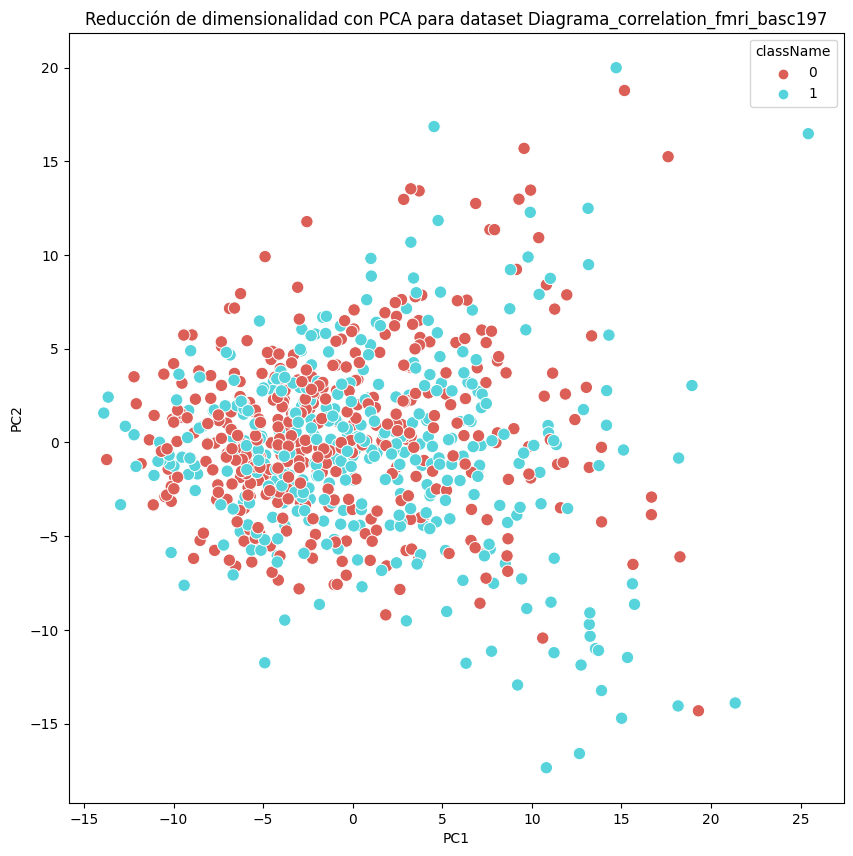

Varianza explicada [0.01141343 0.00734924]
Varianza explicada total 0.018762666319348267


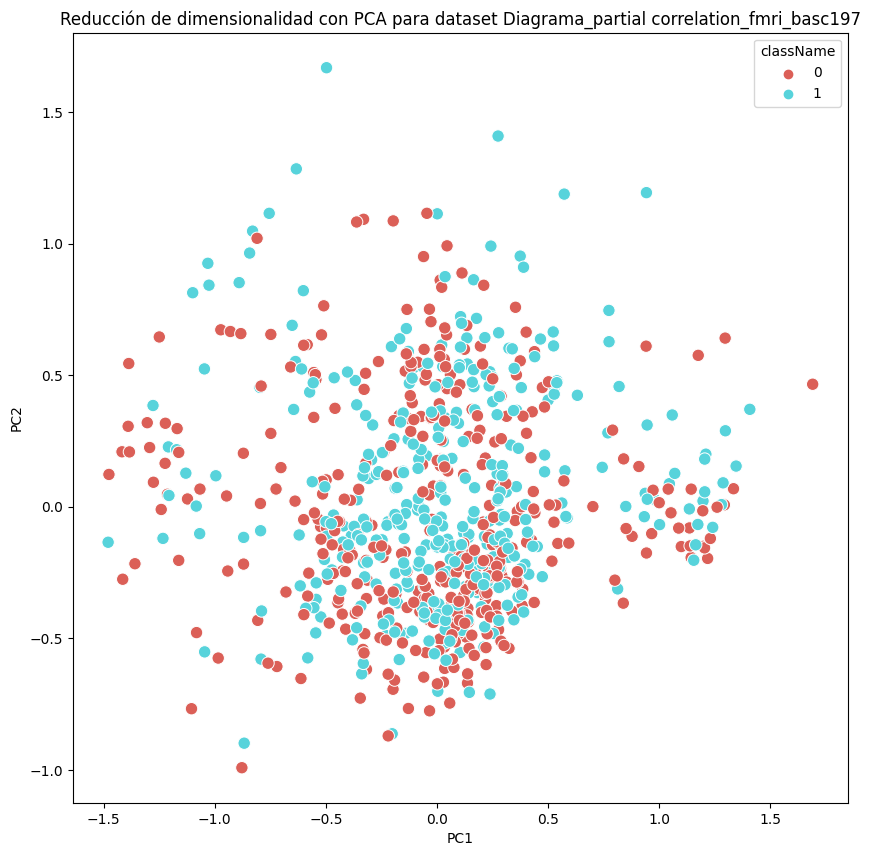

Varianza explicada [0.44362514 0.01323745]
Varianza explicada total 0.4568625928635712


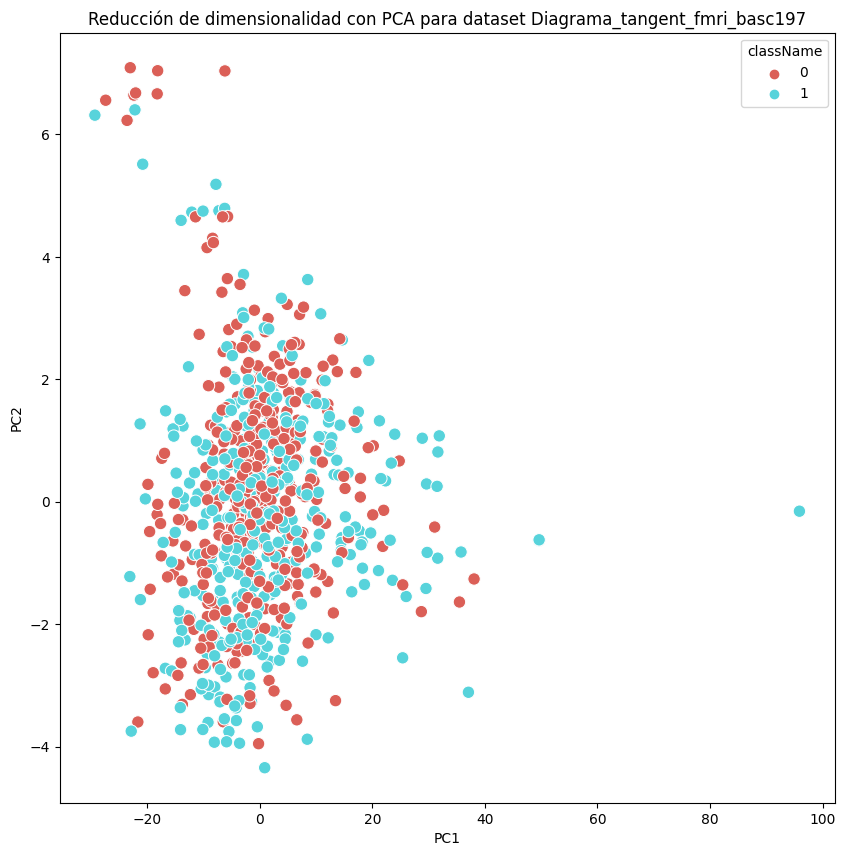

In [ ]:
matrixes = ['correlation', 'partial correlation', 'tangent']
parc_id = 'fmri_basc197'

for tipo_mat in matrixes:
  mats = gen_matrices(pacientes, tipo_matriz = tipo_mat, as_distance = False, keep_pvalue = 1)
  Len = len(mats)
  F = np.array([[]]*Len)
  mats_triag = []
  for i in range(Len):
    mats_triag.append(triag_array(mats[i]))
    
  vec_df = pd.DataFrame(mats_triag)
  name = 'Diagrama_' + tipo_mat + '_' + parc_id
  reduceDim(df=vec_df,target=labs_df['label'], method_class=PCA, df_name= name)

In [ ]:
tipo_mat = 'correlation'
tipo_dist = 'cosine'
parc_id = 'fmri_basc197'
path = 'train/prueba_semana26/train_dgms_' + tipo_mat + '_' + tipo_dist +'_' + parc_id + '.pkl'
with open(path, 'rb') as handle:
    dgms = pkl.load(handle)

In [ ]:
matrixes = ['correlation'] #['correlation', 'partial correlation', 'tangent']
distances = ['dynamic']#['cosine', 'dynamic']
parc_id = 'fmri_basc197'

for tipo_mat in matrixes:
  for tipo_dist in distances:
    paciente_mat = gen_matrices(pacientes_bench, tipo_matriz = tipo_mat, as_distance = tipo_dist, keep_pvalue = 0.05)

    dgms = []
    Len = len(paciente_mat)
    for i in range(Len):
      dgm = ripser_diagram(paciente_mat[i])
      dgms.append(dgm)


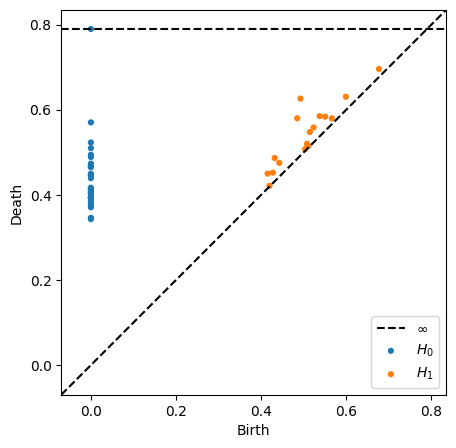

In [ ]:
plt.figure(figsize=(5,5))
plot_diagrams(dgms[37])